In [1]:
# Importing core libraries
import os
import gc
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
import logging


# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Boosting models
import catboost as cat
import xgboost as xgb
import lightgbm as lgb

# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Preprocesing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Utilities
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
from itertools import chain
from sklearn.model_selection import train_test_split
from typing import TypeVar, List, Dict, Tuple
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


# Model selection
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization


# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delt

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/LANL/"
else:
    PATH="../input/"
os.listdir(PATH)

['LANL-Earthquake-Prediction', 'mlip-data', 'basic-features']

In [3]:
train_X = pd.read_csv('../input/mlip-data/train_features.csv')
test_X = pd.read_csv('../input/mlip-data/test_features.csv')
train_y = pd.read_csv('../input/mlip-data/y.csv')

In [4]:
train_X.shape, test_X.shape, train_y.shape

((4195, 1419), (2624, 1419), (4195, 1))

In [5]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.shape

(2624, 1)

In [6]:
# Converting average precision score into a scorer suitable for model selection
mse_scoring = make_scorer(mean_squared_error, greater_is_better=False)
mae_scoring = make_scorer(mean_absolute_error, greater_is_better=False)
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)S
k_fold = KFold(n_splits=7, shuffle=True, random_state=13)

In [7]:

def run_lgb(
    X_tr: PandasDataFrame,
    X_val: PandasDataFrame,
    y_tr: PandasDataFrame,
    y_val: PandasDataFrame,
    test_data: PandasDataFrame,
    params: Dict
):
    """CV train lgb Booster.
    
    Args:
        params: Params for Booster.
        X_train: Training dataset.
        X_test: Testing dataset.
        
    Returns:
        model: Trained model.
        oof_train_lgb:  Training CV predictions.
        oof_test_lgb:  Testing CV predictions.
    """
    
    early_stop = 200
    num_rounds = 10000
    verbose_eval=1000

    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
        
    model = lgb.train(
        params,
        train_set=d_train,
        num_boost_round=num_rounds,
        valid_sets=watchlist,
        verbose_eval=verbose_eval,
        early_stopping_rounds=early_stop
    )

    val_pred = model.predict(X_val, num_iteration=model.best_iteration)    
    prediction = model.predict(test_data, num_iteration=model.best_iteration)
   
    return val_pred, prediction, model.feature_importance(importance_type="gain")
def run_cv_model(
    train_data,
    train_target,
    test_data,
    model_fn, params,
    scoring,
    label='model',
    feature_imp=False,
    n_folds = 5
):
    oof_val = np.zeros(len(train_data))
    predictions = np.zeros(len(test_data))
    oof_predict = np.zeros((n_folds, test_data.shape[0]))
    scores = []

    feature_importance_df = pd.DataFrame()
    
    folds = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_columns = train_data.columns.values
    

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data, train_target.values)):
        strLog = "fold {} for {}".format(fold_, label)
        print(strLog)
        X_tr, X_val = train_data.iloc[trn_idx], train_data.iloc[val_idx]
        y_tr, y_val = train_target.iloc[trn_idx], train_target.iloc[val_idx]
        
        val_pred, prediction, feature_importances = model_fn(
            X_tr, X_val,
            y_tr, y_val,
            test_data,
            params
        )
        score = scoring(y_val, val_pred)
        scores.append(score)

        
        oof_val[val_idx] = val_pred
        
        #feature importance
        if feature_imp == True:
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = train_columns
            fold_importance_df["importance"] = feature_importances[:len(train_columns)]
            fold_importance_df["fold"] = fold_ + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        #predictions
        oof_predict[fold_] = prediction
        predictions += prediction/folds.n_splits
        
        print('CV score: {0:.4f}, std: {1:.4f}.\n'.format(np.mean(score), np.std(score)))  
        print('CV mean score: {0:.4f}, std: {1:.4f}.\n'.format(np.mean(scores), np.std(scores)))  
    


            
    return oof_val, oof_predict, predictions, feature_importance_df, scores

In [8]:
def LGB_bayesian(**lgb_bayes_params):
    
    

    
    lgb_bayes_params['num_leaves'] = int(lgb_bayes_params['num_leaves'] )
    lgb_bayes_params['max_depth'] = int(lgb_bayes_params['max_depth'])
    lgb_bayes_params['min_child_samples'] = int(lgb_bayes_params['min_child_samples'])
    lgb_bayes_params['max_bin'] = int(lgb_bayes_params['max_bin'])
    lgb_bayes_params['subsample_freq'] = int(lgb_bayes_params['subsample_freq'])
    lgb_bayes_params['min_child_weight'] = int(lgb_bayes_params['min_child_weight'])
    lgb_bayes_params['subsample_for_bin'] = int(lgb_bayes_params['subsample_for_bin'])
    lgb_bayes_params['n_estimators'] = int(lgb_bayes_params['n_estimators'])

    
    
    
    fix_lgb_params = {
        'objective':'regression',
        "boosting": "gbdt",
        "metric": 'mae',
    }

    lgb_params = {**fix_lgb_params, **lgb_bayes_params}




    oof_val, oof_predict, predictions, feature_importance_df, scores = run_cv_model(
    train_data=train_X,
    train_target=train_y,
    test_data=test_X,
    model_fn=run_lgb,
    params=lgb_params,
    scoring=mean_absolute_error,
    label="lgb",
    feature_imp=True,
    n_folds=8
)
    
    return -np.mean(scores)

In [9]:


search_spaces = {
        'learning_rate': (0.01, .5),
        'num_leaves': (2, 350),
        'max_depth': (50, 500),
        'min_child_samples': (20, 150), # minimal number of data in one leaf
        'max_bin': (30000, 100000), # max number of bins that feature values will be bucketed
        'subsample': (0.01, 1.0),
        'subsample_freq': (2, 20), # bagging fraction
        'colsample_bytree': (0.01, 1.0), # enabler of bagging fraction
        'min_child_weight': (0, 10), # minimal number of data in one leaf.
        'subsample_for_bin': (100000, 800000), # number of data that sampled for histogram bins
        'reg_lambda': (1e-9, 1000), # L2 regularization
        'reg_alpha': (1e-9, 1.0), # L1 regularization
        'scale_pos_weight': (1e-6, 1000), 
        'n_estimators': (1000, 10000),
        'min_gain_to_split': (0.0, 1.0),
        }

lgb_bo = BayesianOptimization(LGB_bayesian,search_spaces, random_state=7)


In [10]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    lgb_bo.maximize(init_points=50, n_iter=50, acq='ucb')

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | min_ga... | n_esti... | num_le... | reg_alpha | reg_la... | scale_... | subsample | subsam... | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold 0 for lgb
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[154]	training's l1: 1.7122	valid_1's l1: 2.14173
CV score: 2.1417, std: 0.0000.

CV mean score: 2.1417, std: 0.0000.

fold 1 for lgb
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[38]	training's l1: 1.99309	valid_1's l1: 1.986
CV score: 1.9860, std: 0.0000.

CV mean score: 2.0639, std: 0.0779.

fold 2 for lgb
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[82]	training

In [11]:
lgb_bayes_params = lgb_bo.max['params']



lgb_bayes_params['num_leaves'] = int(lgb_bayes_params['num_leaves'] )
lgb_bayes_params['max_depth'] = int(lgb_bayes_params['max_depth'])
lgb_bayes_params['min_child_samples'] = int(lgb_bayes_params['min_child_samples'])
lgb_bayes_params['max_bin'] = int(lgb_bayes_params['max_bin'])
lgb_bayes_params['subsample_freq'] = int(lgb_bayes_params['subsample_freq'])
lgb_bayes_params['min_child_weight'] = int(lgb_bayes_params['min_child_weight'])
lgb_bayes_params['subsample_for_bin'] = int(lgb_bayes_params['subsample_for_bin'])
lgb_bayes_params['n_estimators'] = int(lgb_bayes_params['n_estimators'])

In [12]:
lgb_bayes_params

{'colsample_bytree': 0.07731235427729943,
 'learning_rate': 0.021390697326123965,
 'max_bin': 52576,
 'max_depth': 339,
 'min_child_samples': 119,
 'min_child_weight': 6,
 'min_gain_to_split': 0.4223894968003159,
 'n_estimators': 1560,
 'num_leaves': 25,
 'reg_alpha': 0.7079338662764831,
 'reg_lambda': 368.73133802650744,
 'scale_pos_weight': 363.3220921999365,
 'subsample': 0.9910157826344941,
 'subsample_for_bin': 693174,
 'subsample_freq': 19}

In [13]:
class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Implements five different methods to identify features for removal 
    
        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm
        
    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns
        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.
        
    Attributes
    --------
    
    ops : dict
        Dictionary of operations run and features identified for removal
        
    missing_stats : dataframe
        The fraction of missing values for all features
    
    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold
        
    unique_stats : dataframe
        Number of unique values for all features
    
    record_single_unique : dataframe
        Records the features that have a single unique value
        
    corr_matrix : dataframe
        All correlations between all features in the data
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
        
    feature_importances : dataframe
        All feature importances from the gradient boosting machine
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    
    Notes
    --------
    
        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns
    
    """
    
    def __init__(self, data, labels=None):
        
        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')
        
        self.base_features = list(data.columns)
        self.one_hot_features = None
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.ops = {}
        
        self.one_hot_correlated = False
        
    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending = False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = 
                                                                                                               {'index': 'feature', 
                                                                                                                0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending = True)
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                                0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))
    
    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 
        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        Parameters
        --------
        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features
        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients
        """
        
        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot
        
         # Calculate the correlations between every column
        if one_hot:
            
            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)
            
            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop
        
        print('%d features with a correlation magnitude greater than %0.2f.\n' % (len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self,  feature_importances):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over `n_iterations` to reduce variance. 
        
        Parameters 
        --------
        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True
        task : string
            The machine learning task, either 'classification' or 'regression'
        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs
        """


            
        if self.labels is None:
            raise ValueError("No training labels provided.")
        
        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1, ))


        
        

     

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.
        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 
        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop
    
        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (len(self.feature_importances) -
                                                                            len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                               self.cumulative_importance))
        
    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)
        
        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task = selection_params['task'], eval_metric = selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)
        
        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified, 
                                                                                                  self.data_all.shape[1]))
        
    def check_removal(self, keep_one_hot=True):
        
        """Check the identified features before removal. Returns a list of the unique features identified."""
        
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))
        
        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))
        
        return list(self.all_identified)
        
    
    def remove(self, methods, keep_one_hot = True):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
      
        if methods == 'all':
            
            # Need to use one-hot encoded data as well
            data = self.data_all
                                          
            print('{} methods have been run\n'.format(list(self.ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))
            
        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all
                
            else:
                data = self.data
                
            # Iterate through the specified methods
            for method in methods:
                
                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        features_to_drop = list(features_to_drop)
            
        if not keep_one_hot:
            
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                             
                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))
       
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        if not keep_one_hot:
        	print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
        	print('Removed %d features.' % len(features_to_drop))
        
        return data
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        
        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize = (7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins = np.linspace(0, 1, 11), edgecolor = 'k', color = 'red', linewidth = 1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size = 14); plt.ylabel('Count of Features', size = 14); 
        plt.title("Fraction of Missing Values Histogram", size = 16);
        
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (7, 5))
        plt.ylabel('Frequency', size = 14); plt.xlabel('Unique Values', size = 14); 
        plt.title('Number of Unique Values Histogram', size = 16);
        
    
    def plot_collinear(self, plot_all = False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        if plot_all:
        	corr_matrix_plot = self.corr_matrix
        	title = 'All Correlations'
        
        else:
	        # Identify the correlations that were above the threshold
	        # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
	        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
	                                                list(set(self.record_collinear['drop_feature']))]

	        title = "Correlations Above Threshold"

       
        f, ax = plt.subplots(figsize=(10, 8))
        
        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels 
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels 
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size = 14)
        
    def plot_feature_importances(self, plot_n = 15, threshold = None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.
        Parameters
        --------
        
        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller
        
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances
        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')
            
        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))), 
                self.feature_importances['normalized_importance'][:plot_n], 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault

In [14]:
fix_lgb_params = {
    'objective':'regression',
    "boosting": "gbdt",
    "metric": 'mae',
}

lgb_params = {**fix_lgb_params, **lgb_bayes_params}


oof_val, oof_predict, predictions, feature_importance_df, scores = run_cv_model(
    train_data=train_X,
    train_target=train_y,
    test_data=test_X,
    model_fn=run_lgb,
    params=lgb_params,
    scoring=mean_absolute_error,
    label="lgb",
    feature_imp=True,
    n_folds=8
)

fold 0 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[454]	training's l1: 1.7343	valid_1's l1: 2.12601
CV score: 2.1260, std: 0.0000.

CV mean score: 2.1260, std: 0.0000.

fold 1 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[636]	training's l1: 1.64609	valid_1's l1: 1.94431
CV score: 1.9443, std: 0.0000.

CV mean score: 2.0352, std: 0.0909.

fold 2 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.41809	valid_1's l1: 2.12495
Early stopping, best iteration is:
[1198]	training's l1: 1.32098	valid_1's l1: 2.12195
CV score: 2.1220, std: 0.0000.

CV mean score: 2.0641, std: 0.0847.

fold 3 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[342]	training's l1: 1.83343	valid_1's l1: 2.00698
CV score: 2.0070, std: 0.0000.

CV mean score: 2.0498, std: 0.0774.

fold 4 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's l1: 1.88945	valid_1's l1: 2.03071
CV score: 2.0307, std: 0.0000.

CV mean score: 2.0460, std: 0.0697.

fold 5 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.42827	valid_1's l1: 1.97944
Early stopping, best iteration is:
[1167]	training's l1: 1.34548	valid_1's l1: 1.97575
CV score: 1.9757, std: 0.0000.

CV mean score: 2.0343, std: 0.0688.

fold 6 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[760]	training's l1: 1.55334	valid_1's l1: 2.03957
CV score: 2.0396, std: 0.0000.

CV mean score: 2.0350, std: 0.0637.

fold 7 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[419]	training's l1: 1.77146	valid_1's l1: 2.01027
CV score: 2.0103, std: 0.0000.

CV mean score: 2.0319, std: 0.0601.



In [15]:
submission.to_csv('submission.csv',index=True)
fs = FeatureSelector(data = train_X, labels = train_y)

feature_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean()
feature_importance['feature'] = feature_importance.index

In [16]:

fs.identify_zero_importance(feature_importance)


57 features with zero importance after one-hot encoding.



In [17]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 1419 original features
There are 0 one-hot features


In [18]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[0:10]

['fftr_binned_entropy_10',
 'abs_percentile_75',
 'abs_percentile_80',
 'abs_percentile_90',
 'fftr_av_change_rate_roll_std_100',
 'percentile_40',
 'percentile_30',
 'percentile_25',
 'fftr_av_change_rate_roll_std_1000',
 'fftr_av_change_rate_roll_std_10000']

In [19]:

fs.identify_low_importance(cumulative_importance = 0.99)


1030 features required for cumulative importance of 0.99 after one hot encoding.
389 features do not contribute to cumulative importance of 0.99.



In [20]:
all_to_remove = fs.check_removal()

Total of 389 features identified for removal


In [21]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

['zero_importance', 'low_importance'] methods have been run

Removed 389 features including one-hot features.


In [22]:
train_removed_all.shape

(4195, 1030)

In [23]:
feature = train_removed_all.columns
test_df = test_X[feature]
train_df = train_removed_all

In [24]:
oof_val, oof_predict, predictions, feature_importance_df, scores = run_cv_model(
    train_data=train_df,
    train_target=train_y,
    test_data=test_df,
    model_fn=run_lgb,
    params=lgb_params,
    scoring=mean_absolute_error,
    label="lgb",
    feature_imp=True,
    n_folds=8

)

fold 0 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[453]	training's l1: 1.73722	valid_1's l1: 2.12686
CV score: 2.1269, std: 0.0000.

CV mean score: 2.1269, std: 0.0000.

fold 1 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[471]	training's l1: 1.75537	valid_1's l1: 1.95382
CV score: 1.9538, std: 0.0000.

CV mean score: 2.0403, std: 0.0865.

fold 2 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[706]	training's l1: 1.57979	valid_1's l1: 2.11461
CV score: 2.1146, std: 0.0000.

CV mean score: 2.0651, std: 0.0788.

fold 3 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[497]	training's l1: 1.72376	valid_1's l1: 2.0104
CV score: 2.0104, std: 0.0000.

CV mean score: 2.0514, std: 0.0723.

fold 4 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[260]	training's l1: 1.89379	valid_1's l1: 2.03423
CV score: 2.0342, std: 0.0000.

CV mean score: 2.0480, std: 0.0650.

fold 5 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.43461	valid_1's l1: 1.99501
Early stopping, best iteration is:
[900]	training's l1: 1.48716	valid_1's l1: 1.9928
CV score: 1.9928, std: 0.0000.

CV mean score: 2.0388, std: 0.0628.

fold 6 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.42887	valid_1's l1: 2.04211
Early stopping, best iteration is:
[975]	training's l1: 1.44226	valid_1's l1: 2.04048
CV score: 2.0405, std: 0.0000.

CV mean score: 2.0390, std: 0.0581.

fold 7 for lgb


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[523]	training's l1: 1.70471	valid_1's l1: 2.00701
CV score: 2.0070, std: 0.0000.

CV mean score: 2.0350, std: 0.0554.



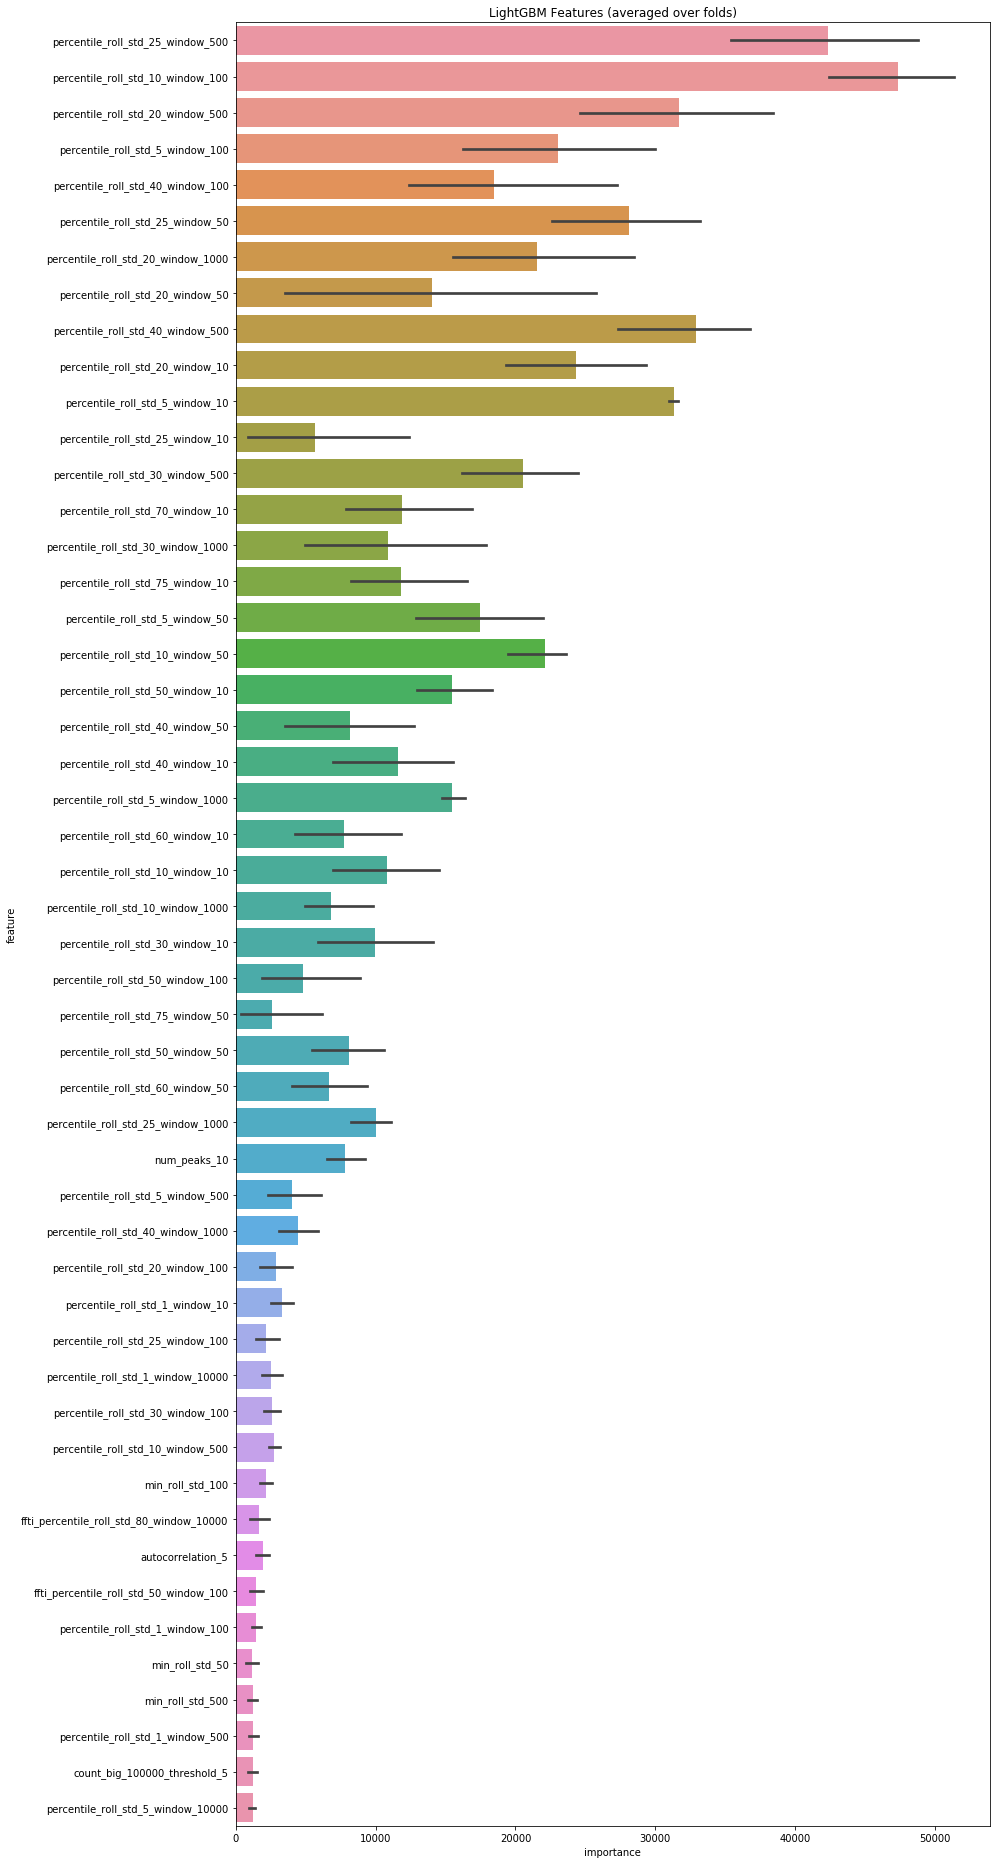

In [25]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [26]:
submission.time_to_failure = predictions
submission.to_csv('clean_submission.csv',index=True)